In [ ]:
import os
import numpy as np
import pyrubberband

from config import config
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio
import random
from scipy import fft
import noisereduce as nr
import soundfile
import time
from tqdm import tqdm
import pickle
import lzma
import matplotlib.pyplot as plt
import glob
import seaborn as sb
import pathlib
import torchaudio
import torch
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
%load_ext autoreload
%autoreload 2

## Add 2021 Data

I do this just by actually removing the data which does not overlap

In [9]:
import shutil
folders22 = os.listdir('../datasets/birdclef22/train_audio/')
folders21 = os.listdir('../datasets/birdclef-2021/train_short_audio/')
for folder in folders21:
    if folder in folders22:
        continue
    else:
        shutil.rmtree(os.path.join('../datasets/birdclef-2021/train_short_audio/', folder))


# Generate augmented df

In [ ]:
df = pd.read_csv('../datasets/numpy_mel/train_metadata.csv')
root = '../datasets/numpy_mel'

In [ ]:
# create new augmented df
cols = ['primary_label', 'secondary_labels', 'path']
df_augmented = pd.DataFrame(columns=cols)

for idx, item in tqdm(df.iterrows()):
    path_bird = item['filename'].split('.')[0]
    path = os.path.join(root, 'data', path_bird)
    augmented_files = glob.glob(f'{path}*')
    
    # add new row to the augmented for each additional file
    for f in augmented_files:
        data = {
            'path': [f.replace('\\', '/')],
            'file': path_bird,
            'primary_label': [item.primary_label],
            'secondary_labels': [item.secondary_labels]
        }
        new = pd.DataFrame(data=data)
        df_augmented = pd.concat((df_augmented, new), axis=0, ignore_index=True)

In [ ]:
df_augmented.info()

In [ ]:
df_augmented.head()

In [ ]:
from dataset import combine_labels
from sklearn.preprocessing import LabelEncoder

In [ ]:
mapping = df['primary_label'].unique()

In [ ]:
df = df_augmented.copy()
classes = mapping
df['label'] = [combine_labels(df['primary_label'][idx], df['secondary_labels'][idx]) for idx in range(len(df))]
secondary = [np.sum([np.where(item == classes, 1, 0) for item in row], axis=0) for row in df['label']]
df['sec_enc'] = secondary

In [ ]:
encoder = LabelEncoder()
primary = encoder.fit_transform(df['primary_label'])
df['pri_enc'] = primary

In [ ]:
maps = pd.DataFrame(mapping)

In [ ]:
maps.head()

In [ ]:
maps.to_csv(f'{root}/mapping.csv')

In [ ]:
df.to_csv(f'{root}/augmented.csv')

In [ ]:
df = pd.read_csv('../datasets/numpy_mel/augmented.csv')

# Test Augmentations

In [ ]:
import colorednoise as cn

def add_white_noise(y, min_snr=5, max_snr=20):
    snr = np.random.uniform(min_snr, max_snr)
    a_noise = 1 / (10 ** (snr / 20))

    white_noise = np.random.randn(len(y))
    a_white = np.sqrt(white_noise ** 2).max()
    augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
    return augmented


def add_pink_noise(y, min_snr=5, max_snr=20):
    snr = np.random.uniform(min_snr, max_snr)
    a_noise = 1 / (10 ** (snr / 20))

    pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
    a_pink = np.sqrt(pink_noise ** 2).max()
    augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
    return augmented


def add_random_noise(y, max_noise_level=0.5):
    noise_level = np.random.uniform(0, max_noise_level)
    noise = np.random.randn(len(y))
    augmented = (y + noise * noise_level).astype(y.dtype)
    return augmented


def add_noise(y, noise_scale=0.5):
    noise_fn = [add_white_noise, add_pink_noise, add_random_noise]
    return random.choice(noise_fn)(y) * noise_scale

In [ ]:
y = np.zeros(22_050*30)
y_noisy = add_noise(y, noise_scale=0.2)
plt.plot(y, color='r')
plt.plot(y_noisy, alpha=0.2, color='k')

In [ ]:
def get_mel(y, reduce_noise=True):

    # extract features
    mel_spec = librosa.feature.melspectrogram(y=y, sr=22050, fmin=200, fmax=10000, n_mels=64, n_fft=1024)
    # convert to db and normalize to max=0dB
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max, top_db=80)

    return mel_spec

In [ ]:
librosa.display.specshow(get_mel(y_noisy))
print(y_noisy.max(), y_noisy.min())

In [ ]:
y_noisy = torch.FloatTensor(y_noisy)
spec = torchaudio.transforms.MelSpectrogram(sample_rate=22_050, n_fft=1024, f_min=200, f_max=10_000, hop_length=512, n_mels=64, normalized=True)(y_noisy)
spec = torchaudio.transforms.AmplitudeToDB(top_db=80)(spec)
print(spec.max(), spec.min(), spec.shape)
librosa.display.specshow(spec.cpu().numpy())

# Test Dataset

In [ ]:
from dataset import get_dataset
from helpers import DotDict
args = DotDict({'data_path': '../datasets/numpy_mel/', 'use_secondary': False})
datasets = get_dataset(args)
import colorednoise as cn
import matplotlib.pyplot as plt
import librosa, librosa.display

In [ ]:
train_gen, test_gen = datasets[0]

In [ ]:
for idx, item in enumerate(train_gen):
    img, label = item
    img, label = img[0], label[0]
    img = img.squeeze().cpu().numpy()
    label = label.squeeze().cpu().numpy()
    print(img.shape)
    plt.title(label)
    librosa.display.specshow(img)
    plt.show()
    if idx > 2:
        break

# Show the distribution

In [1]:
import pandas as pd
import seaborn as sb
import os
import matplotlib.pyplot as plt

In [2]:
df_orig = pd.DataFrame()
df_orig['class'] = os.listdir('../datasets/birdclef22/train_audio/')
l = []
for folder in df_orig['class']:
    l.append(len(os.listdir(f'../datasets/birdclef22/train_audio/{folder}')))

df_orig['num'] = l

In [25]:
df = pd.DataFrame()
df['class'] = os.listdir('../datasets/numpy_mel/data/')
l = []
for folder in df['class']:
    l.append(len(os.listdir(f'../datasets/numpy_mel/data/{folder}')))

df['num'] = l

In [4]:
df_diff = pd.DataFrame()
df_diff['class'] = df_orig['class']
df_diff['diff'] = df['num'] - df_orig['num']

In [5]:
sb.set_style('white')
sb.set_theme("notebook")

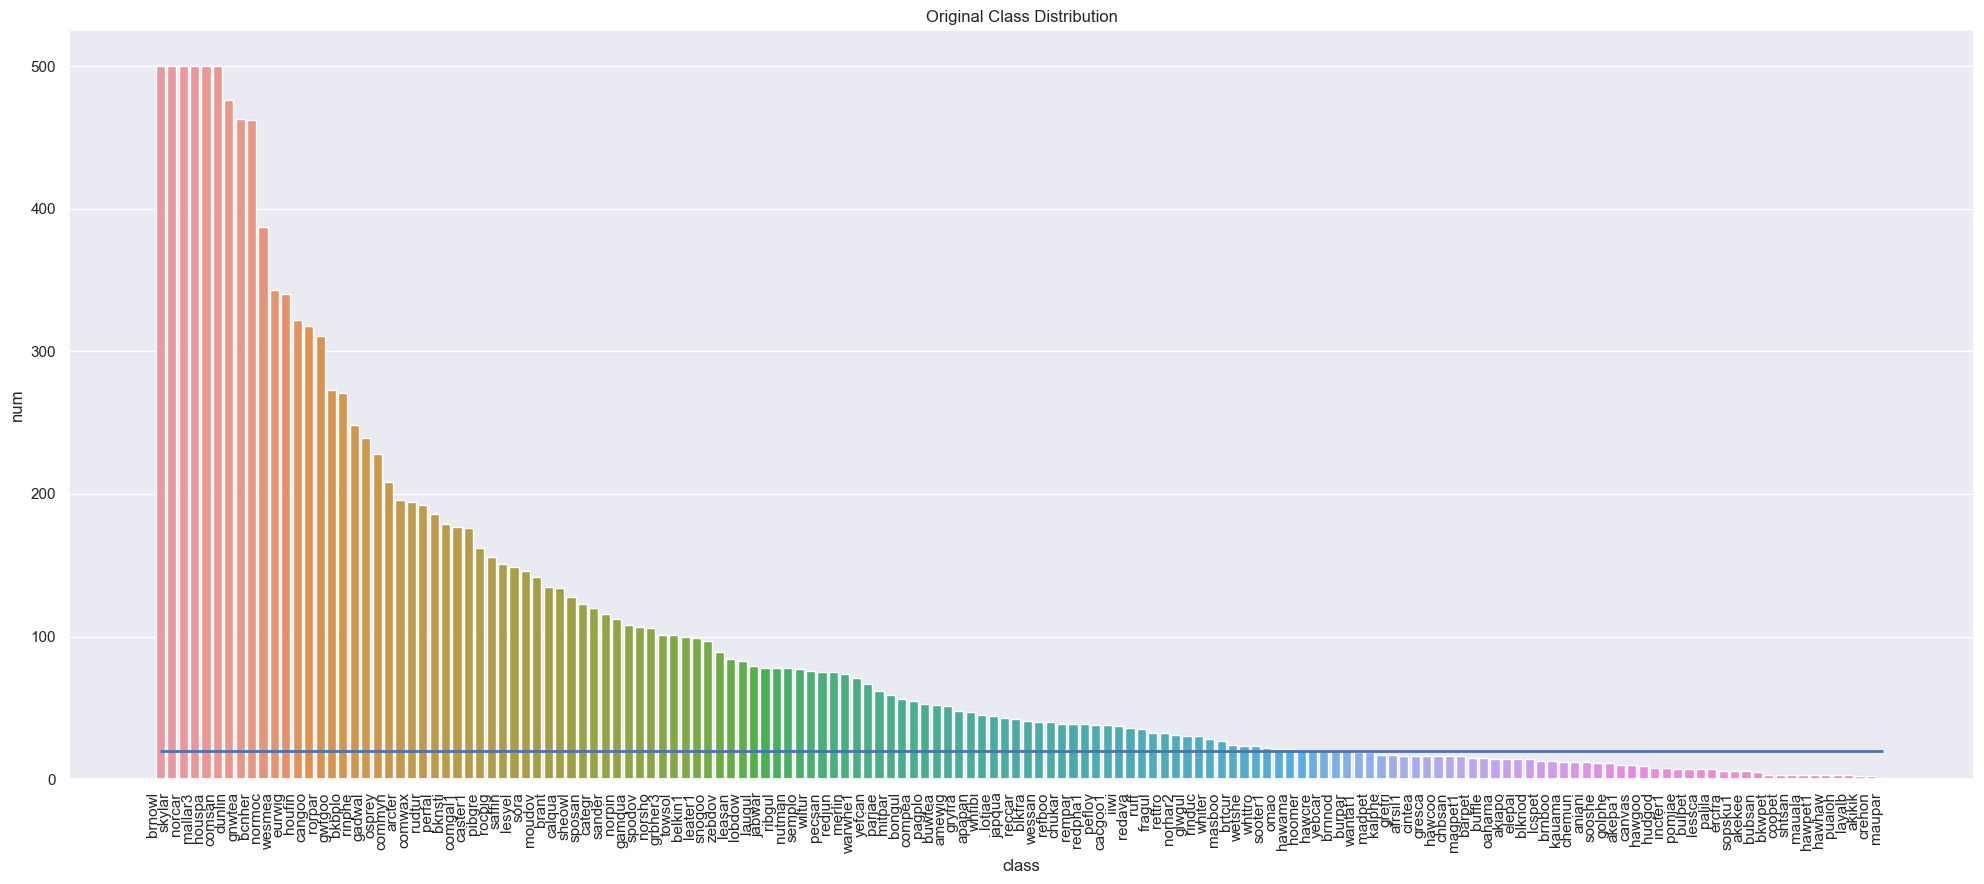

In [7]:
fig, ax = plt.subplots(figsize=(20,9))
plt.title("Original Class Distribution")
ax = sb.barplot(data=df_orig.sort_values('num', ascending=False), x='class', y='num')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.hlines(y=20, xmin=0, xmax=151, linewidth=2)
plt.savefig('original_dist', dpi=200)
plt.show()

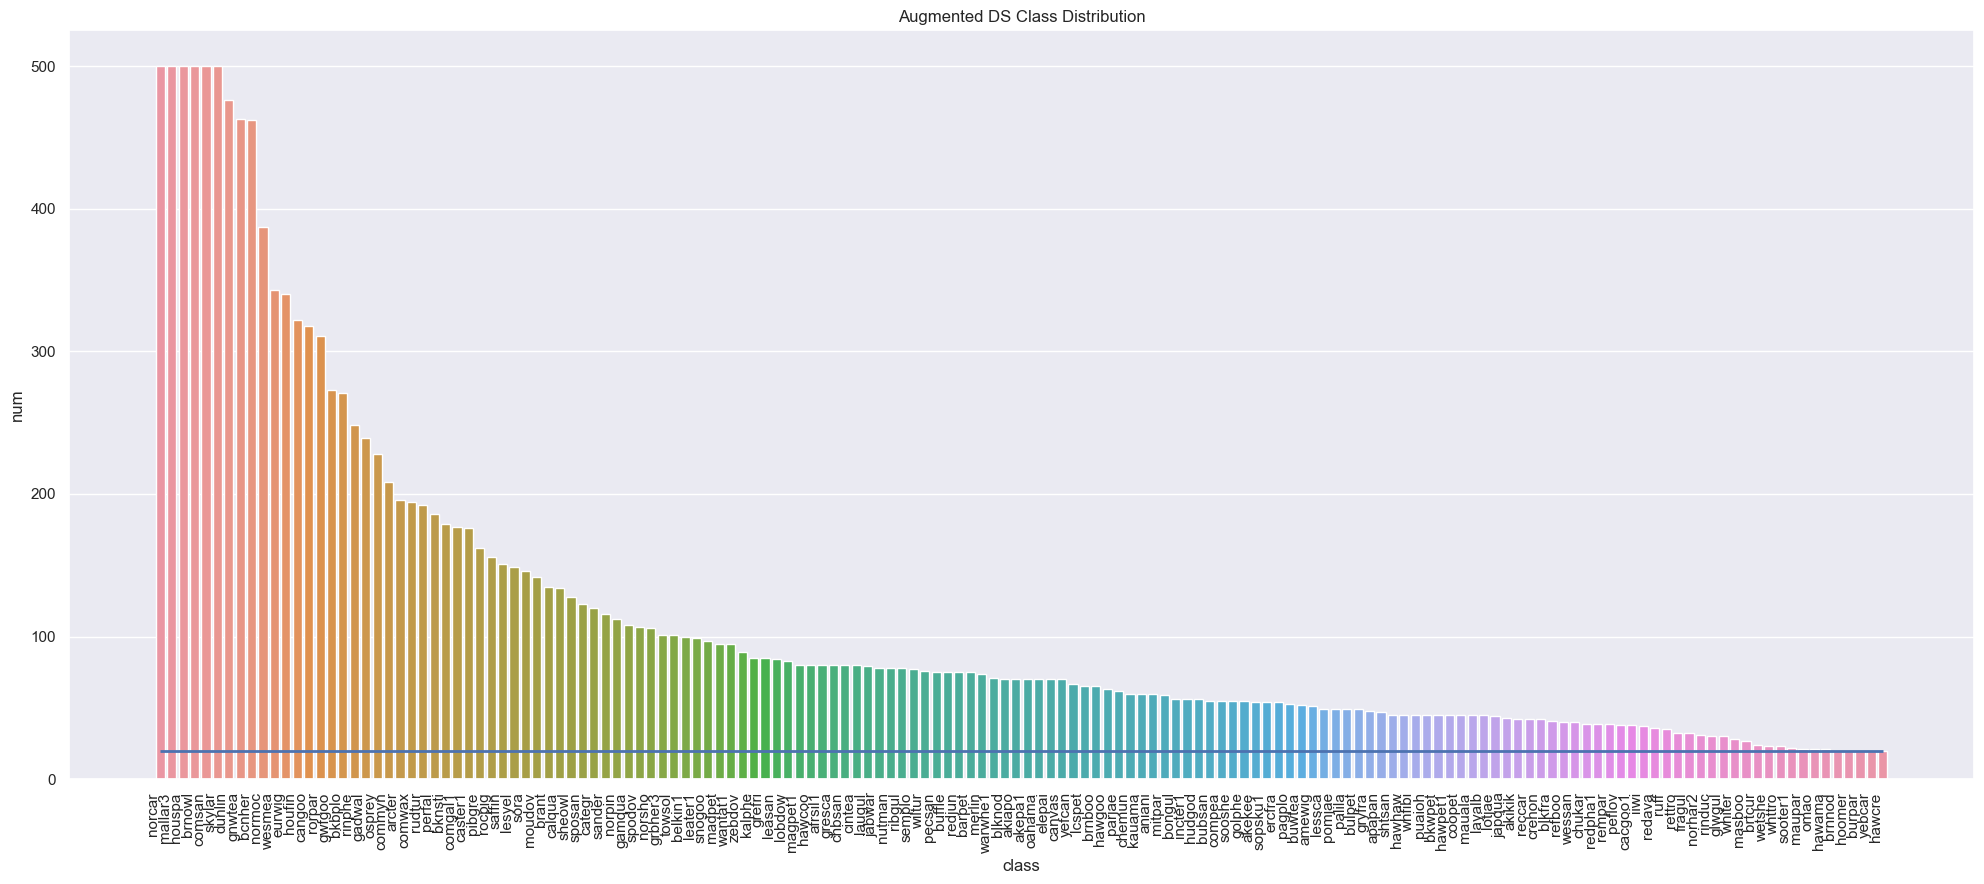

In [26]:
fig, ax = plt.subplots(figsize=(20,9))
plt.title("Augmented DS Class Distribution")
ax = sb.barplot(data=df.sort_values('num', ascending=False), x='class', y='num')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.hlines(y=20, xmin=0, xmax=151, linewidth=2)
plt.tight_layout()
plt.savefig('augmented_dist', dpi=200)
plt.show()

In [27]:
df_21 = pd.DataFrame()
df_21['class'] = os.listdir('../data_processing/birdclef21/')
l = []
for folder in df_21['class']:
    l.append(len(os.listdir(f'../data_processing/birdclef21/{folder}')))

df_21['num'] = l

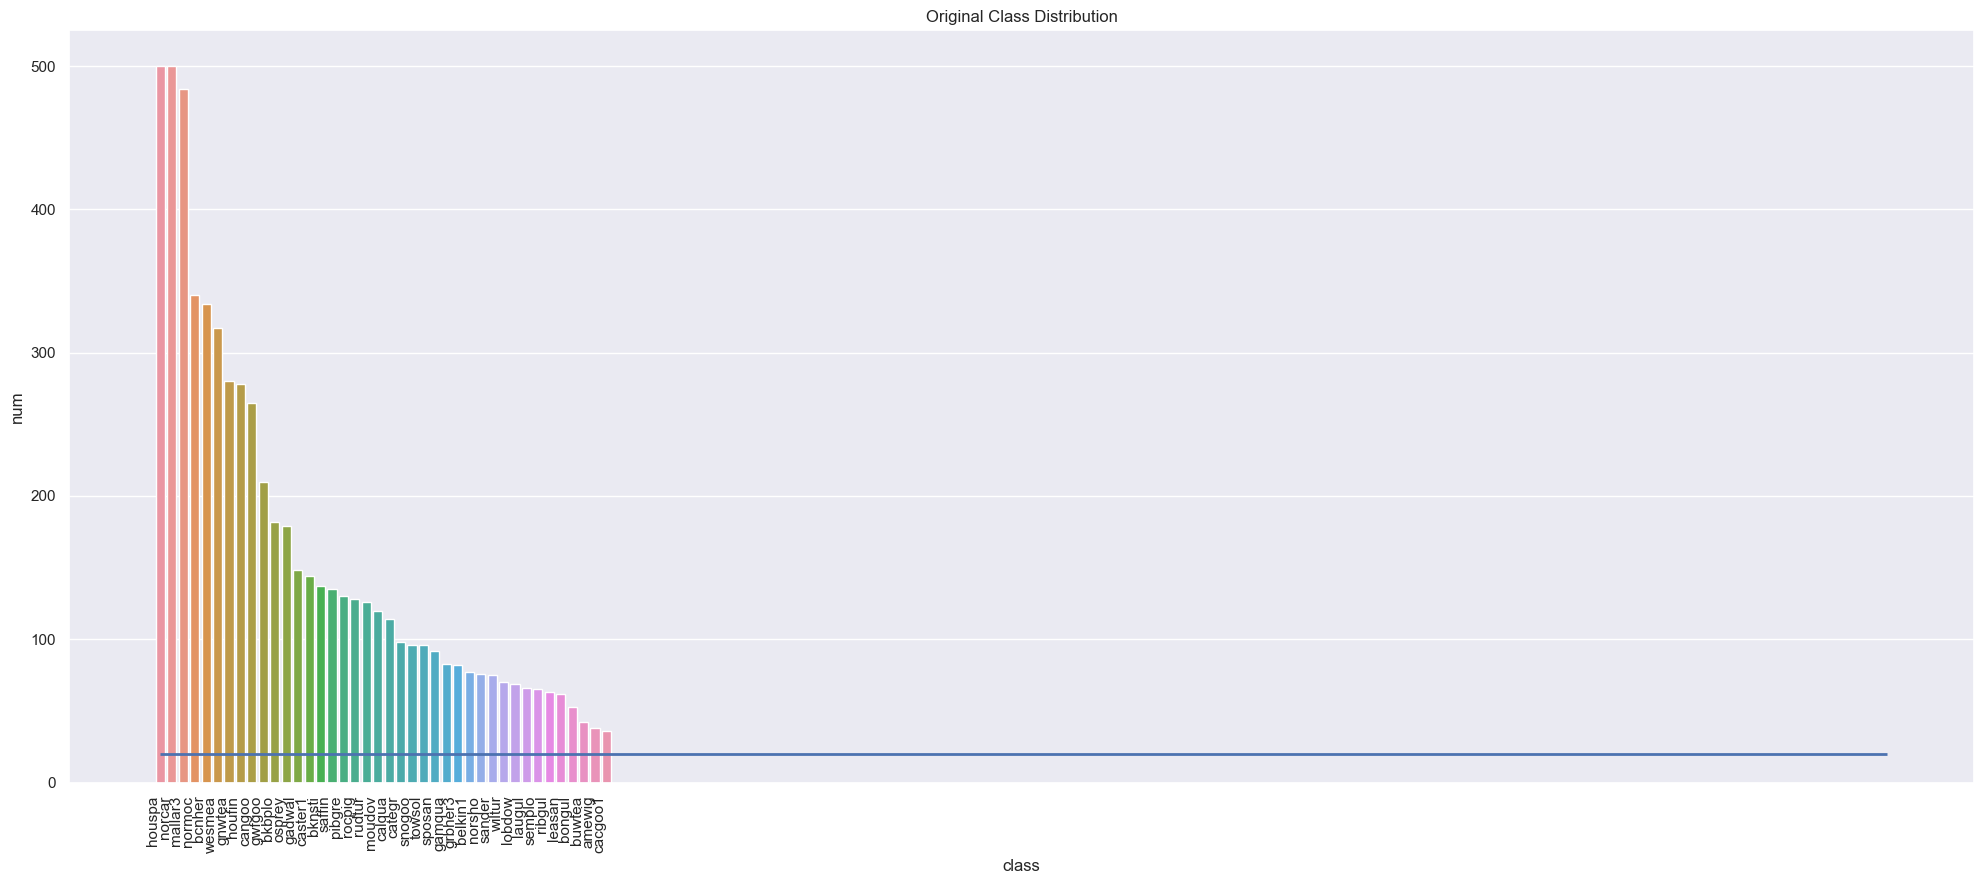

In [28]:
fig, ax = plt.subplots(figsize=(20,9))
plt.title("Original Class Distribution")
ax = sb.barplot(data=df_21.sort_values('num', ascending=False), x='class', y='num')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.hlines(y=20, xmin=0, xmax=151, linewidth=2)
plt.savefig('original_dist', dpi=200)
plt.show()

In [29]:
join = pd.concat([df, df_21]).groupby(['class']).sum().reset_index()

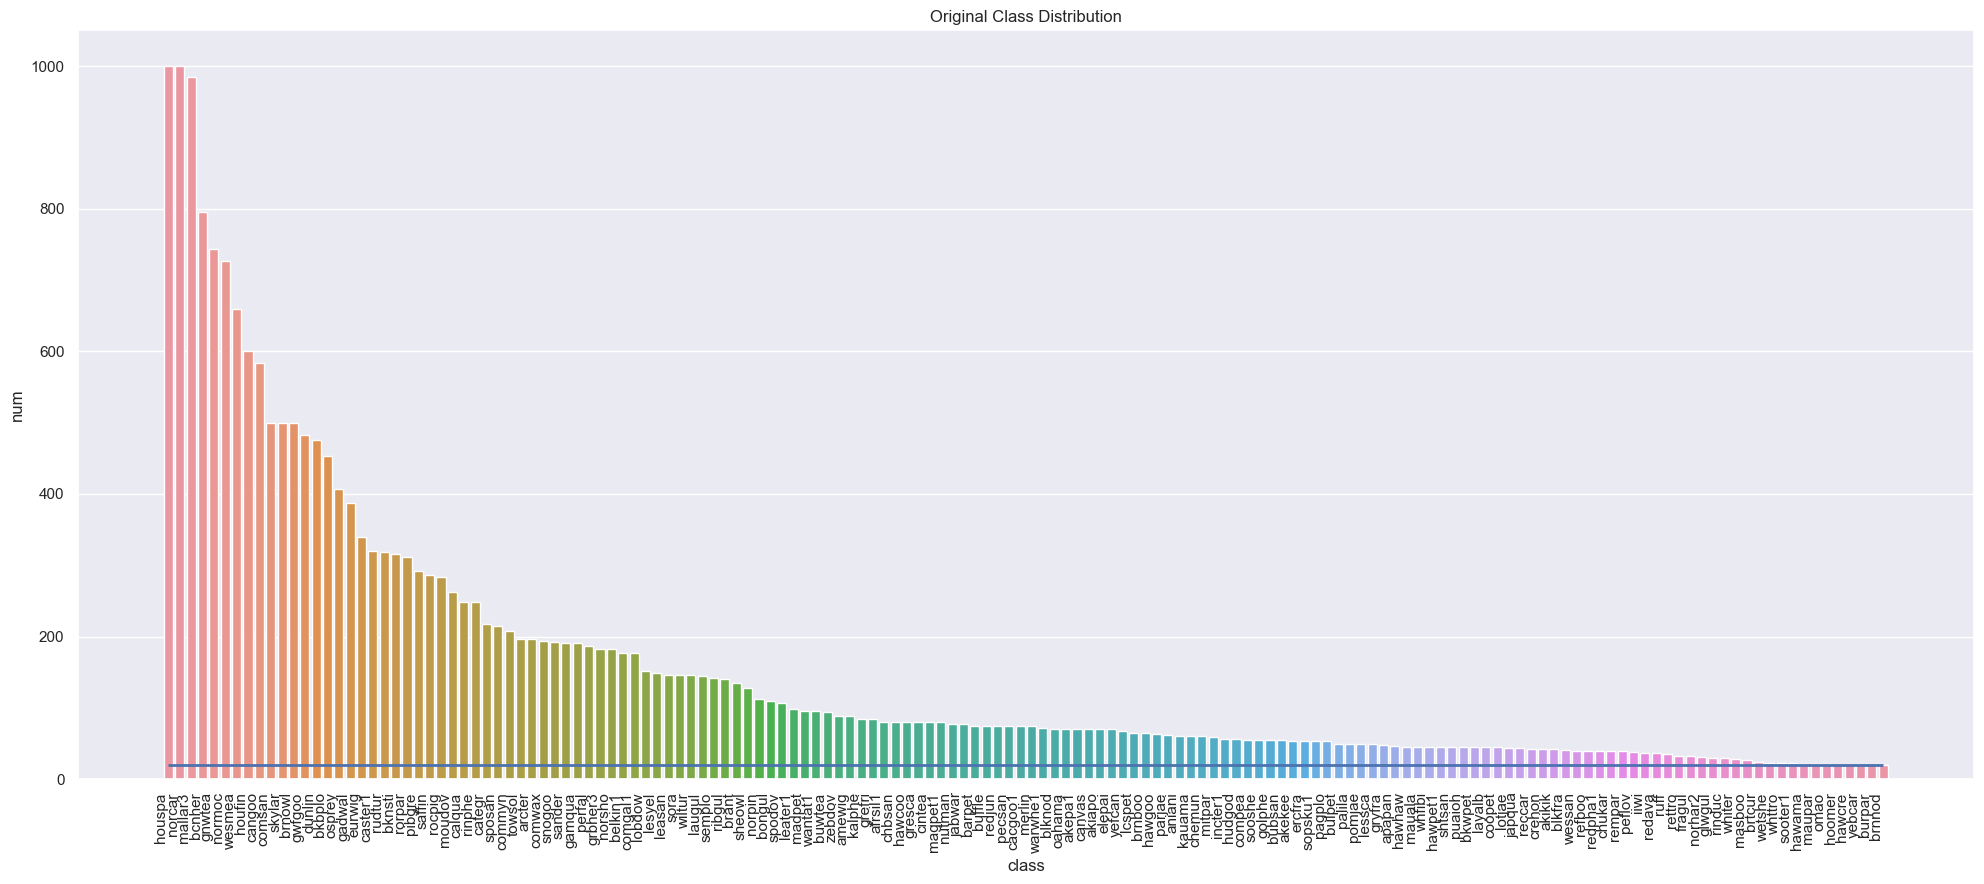

In [31]:
fig, ax = plt.subplots(figsize=(20,9))
plt.title("Original Class Distribution")
ax = sb.barplot(data=join.sort_values('num', ascending=False), x='class', y='num')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.hlines(y=20, xmin=0, xmax=151, linewidth=2)
plt.savefig('original_dist', dpi=200)
plt.show()

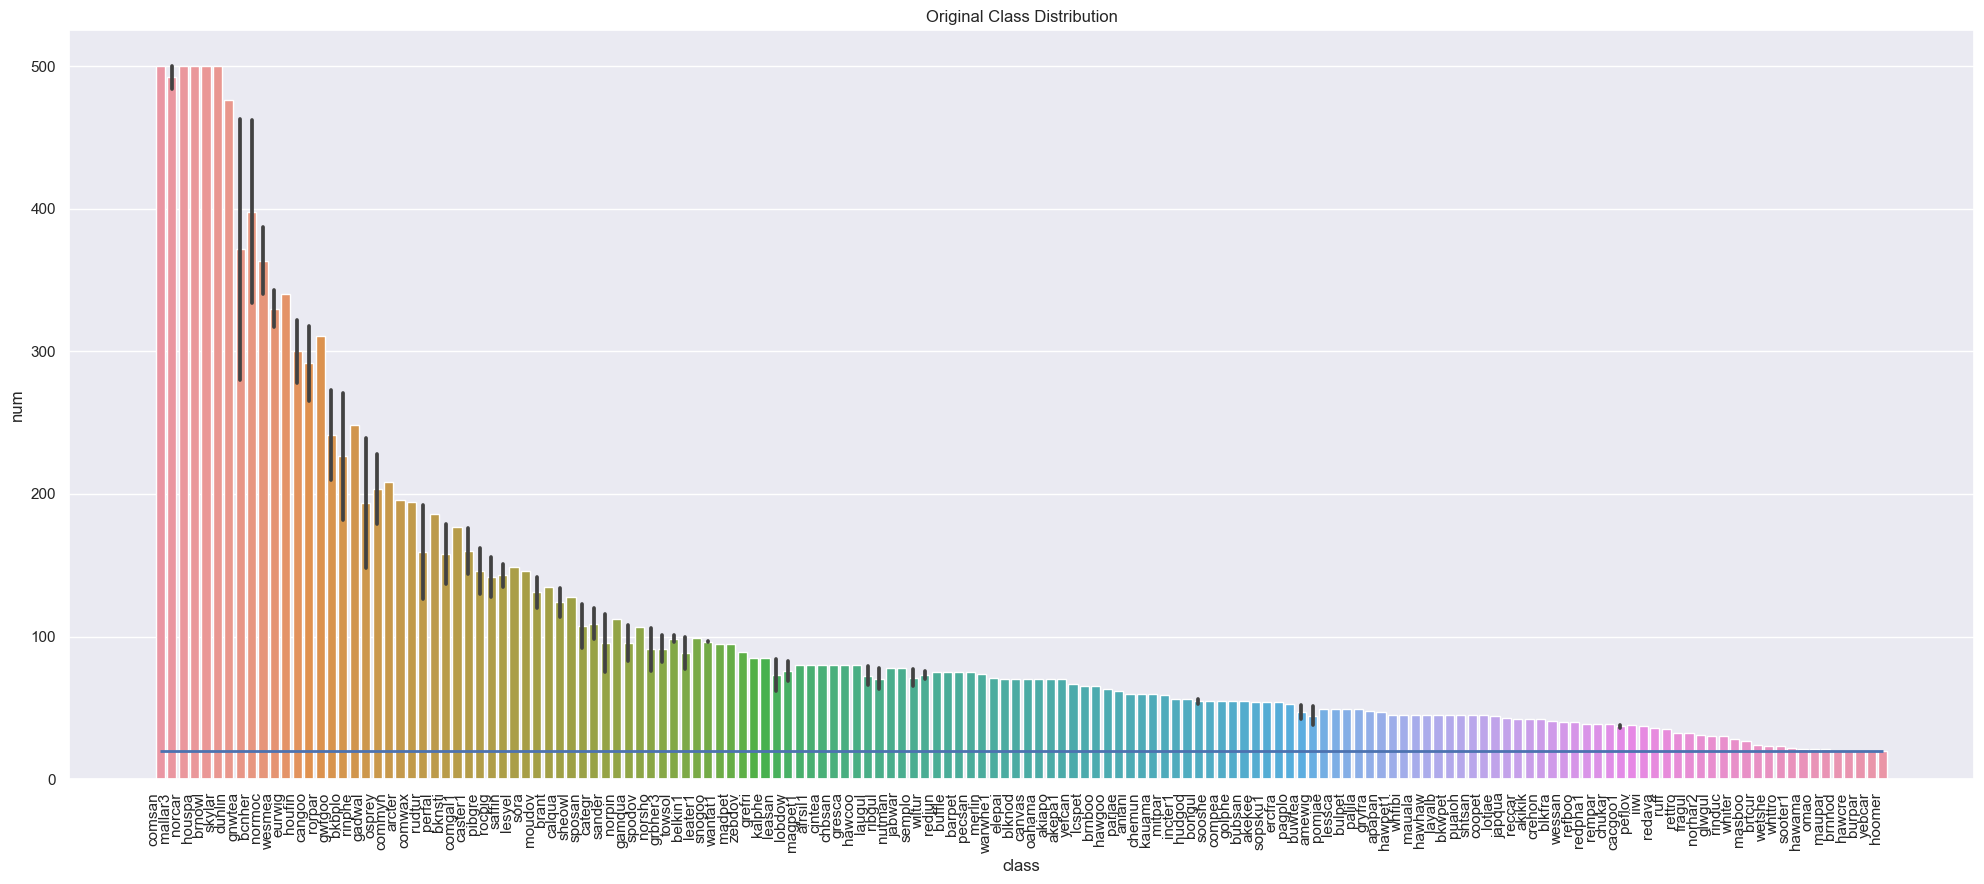

In [14]:
fig, ax = plt.subplots(figsize=(20,9))
plt.title("Original Class Distribution")
ax = sb.barplot(data=join.sort_values('num', ascending=False), x='class', y='num')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.hlines(y=20, xmin=0, xmax=151, linewidth=2)
plt.savefig('original_dist', dpi=200)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))
plt.title("Augmentation per Class")
ax = sb.barplot(data=df_orig, x='class', y='num', color='k')
ax = sb.barplot(data=df_diff, x='class', y='diff', color='r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.savefig('augemnted_detail', dpi=200)
plt.show()

# Random

In [ ]:
from dataset import BirdClefMelDataset

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [ ]:
df = pd.read_csv('../datasets/numpy_mel/augmented.csv')

In [ ]:
args = dotdict({'data_path': '../datasets/numpy_mel/'})

In [ ]:
ds = BirdClefMelDataset(df=df, args=args, use_secondary=True)

In [ ]:
p = os.path.relpath('..\datasets\\numpy_mel\data\\afrsil1\XC177993_s0_ps_-1.npz')

In [ ]:
img = np.load(p, allow_pickle=True)
img = img.f.mel

In [ ]:
librosa.display.specshow(img)

In [ ]:
print(img.min(), img.max())

In [ ]:
torch.tensor([[1,1,1,1], [1,2,3,4]]).reshape((-1,1,1)).view(-1)

In [ ]:
mel_normal = img
mel_normal = mel_normal - np.min(mel_normal)
if np.max(mel_normal) != 0:
    mel_normal /= np.max(mel_normal)

In [ ]:
print(mel_normal.min(), mel_normal.max())

In [ ]:
librosa.display.specshow(mel_normal)

In [ ]:
img, target = ds.__getitem__(10)

In [ ]:
librosa.display.specshow(img.squeeze().numpy())

In [ ]:
target

In [ ]:
import torch
from models import loss_bcefocal

In [ ]:
target = torch.tensor([0,0,0,0,1])
pred =   torch.tensor([0,0.99,0,0,0.78])

In [ ]:
loss_bcefocal(pred, target)

In [ ]:
sr = 20_000

In [ ]:
import torchaudio

In [ ]:
# librosa vs npy loading
test_samples = df.sample(100)['filename']
total_samples = 0
start = time.time()
for t in tqdm(test_samples):
    file = os.path.join('../datasets/birdclef22/train_audio/', t)
    #y = torchaudio.load(file)[0].numpy()
    #shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=2, res_type='kaiser_fast')
    y, sr = librosa.load(file, sr=None, res_type='kaiser_fast', duration=None)
    samps = len(y)
    total_samples += samps
stop = time.time()

In [ ]:
dataset_length = len(df)
total = stop-start
avg = total / 100
avg_per_time = total_samples / 100
print("total time", total)
print("average time", avg)
print("samples total", avg_per_time)
print("time to load ds", dataset_length*avg)

Kaiser fast
-----------------
    total time 35.63866972923279
    average time 0.35638669729232786
    samples total 912355.55
    time to load ds 5293.0552281856535

Kaiser best
-----------------
    total time 80.84255528450012
    average time 0.8084255528450012
    samples total 943532.88
    time to load ds 12006.736310853958

Kaiser fast 30s
-----------------
    total time 16.148550510406494
    average time 0.16148550510406495
    samples total 413094.96
    time to load ds 2398.3827218055726

Loading times:
kaiser_best : 

In [ ]:
sample = random.choice(samples)
sample_reduced = nr.reduce_noise(sample, sr=sr)
shift = librosa.effects.pitch_shift(sample, sr=sr, n_steps=1, res_type='kaiser_fast')

In [ ]:
Audio(shift, rate=sr)

In [ ]:
Audio(sample, rate=sr)

In [ ]:
Audio(sample_reduced, rate=sr)

In [ ]:
os.remove('test.npy')
os.remove('test.ogg')

In [ ]:
np.savez_compressed('test.npz', sample)

In [ ]:
soundfile.write('test.ogg', sample, sr, format='ogg')